**Predicting Severity:** Predicting the severity of accidents is particularly important because it allows for timely and appropriate responses. By assessing accident severity, responders can allocate resources, prioritize medical treatment, and dispatch appropriate personnel. Predictive models can take into account various factors such as road conditions, weather, vehicle type, and collision type to estimate the likelihood of severe outcomes, helping improve emergency response and medical care.

#### librerias

In [1]:
import os
import re
import string
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import h2o
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from math import radians, sin, cos, sqrt, atan2
from shapely.geometry import Polygon
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from statsmodels.tools.tools import add_constant

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML
from tpot import TPOTClassifier


d:\MIAD\despliegue de soluciones\Proyecto_Accidentes_Transito_EU\DSA_Proyecto_AccidentesTransito\.venv\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
# Definir la ruta a la carpeta Data
Data_path = '../Data'

# Cargar los datos
file_path = os.path.join(Data_path, 'US_Accidents_March23_v2.csv')
df = pd.read_csv(file_path)
df.dropna(inplace=True)

# Tomar una muestra aleatoria del 10% de los datos
sample_df = df.sample(frac=0.1, random_state=42)  # random_state asegura reproducibilidad

# Mostrar las primeras filas de la muestra
print("Primeras filas de la muestra (10% del conjunto de datos):")
print('filas / columnas', sample_df.shape)
print(sample_df.head())

Primeras filas de la muestra (10% del conjunto de datos):
filas / columnas (77280, 146)
               ID  Severity  Distance(mi)  Temperature(F)  Wind_Chill(F)  \
485866  A-7114163         2         0.000            65.0           65.0   
518491  A-4403211         2         0.078            83.0           83.0   
534622   A-293466         2         0.000            98.6           68.0   
646447   A-266393         2         0.010            64.4           74.0   
311927  A-3194575         3         1.155            52.5           57.0   

        Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
485866         52.0         29.69            10.0             18.1   
518491         27.0         29.18            10.0             10.0   
534622         29.0         29.81            10.0              9.2   
646447        100.0         30.14            10.0              9.2   
311927         27.0         30.19            10.0              8.1   

        Precipitation(in)  ...  Te

In [3]:
def classification_task(model, X_train_scaled, y_train, X_test_scaled, y_test, predic, model_name):
    """
    Evalúa el rendimiento de un modelo de clasificación y devuelve un DataFrame con varias métricas.

    Parámetros:
    - model: objeto del modelo de clasificación entrenado.
    - X_train_scaled: conjunto de datos de entrenamiento escalado.
    - y_train: etiquetas verdaderas del conjunto de entrenamiento.
    - X_test_scaled: conjunto de datos de prueba escalado.
    - y_test: etiquetas verdaderas del conjunto de prueba.
    - predic: predicciones del modelo en el conjunto de prueba.
    - model_name: nombre del modelo, utilizado como índice en el DataFrame de resultados.

    Retorno:
    - perf_df: DataFrame con las métricas de rendimiento del modelo.
    """
    
    # Crear el DataFrame con las métricas de evaluación
    perf_df = pd.DataFrame({
        'Train_Score': model.score(X_train_scaled, y_train),         # Puntaje en el conjunto de entrenamiento
        'Test_Score': model.score(X_test_scaled, y_test),            # Puntaje en el conjunto de prueba
        'Precision_Score': precision_score(y_test, predic, average='weighted'),  # Precisión ponderada
        'Recall_Score': recall_score(y_test, predic, average='weighted'),        # Recall ponderado
        'F1_Score': f1_score(y_test, predic, average='weighted'),               # F1 Score ponderado
        'accuracy': accuracy_score(y_test, predic)                              # Exactitud global
    }, index=[model_name])
    
    return perf_df

In [4]:
# seleccion variable respuesta
X = sample_df.drop('Severity', axis=1)
y= sample_df['Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
# Crea un DataFrame con X_test, los valores reales de y_test, y las predicciones
results_df = X_test.copy()  # Copia X_test para mantener sus columnas

X_train = X_train.drop('ID', axis=1)
X_test = X_test.drop('ID', axis=1)

### Desbalanceo variable objetivo
Es fundamental evaluar el equilibrio de la variable objetivo, especialmente en tareas de clasificación. Una variable objetivo desequilibrada ocurre cuando una clase (o categoría) tiene significativamente más casos que las demás, lo que puede generar desafíos que afectan el entrenamiento, la evaluación y la generalización del modelo.

In [31]:
# Inicializar el objeto SMOTETomek
smt = SMOTETomek(random_state=42)

# Aplicar SMOTETomek al conjunto de entrenamiento
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

# Mostrar el balance de clases antes y después
print("Distribución de clases antes de SMOTETomek:")
print(pd.Series(y_train).value_counts())
print("\nDistribución de clases después de SMOTETomek:")
print(pd.Series(y_resampled).value_counts())

Distribución de clases antes de SMOTETomek:
Severity
2    43009
3     9225
4     1405
1      457
Name: count, dtype: int64

Distribución de clases después de SMOTETomek:
Severity
1    42997
4    42941
3    42824
2    42788
Name: count, dtype: int64


#### RandomForestClassifier

In [5]:
# definicion del modelo
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)  

y_pred = rf_classifier.predict(X_test)
Eval_Rf= classification_task(rf_classifier,X_train, y_train ,X_test ,y_test, y_pred ,'Random Forest')
Eval_Rf

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random Forest,0.999982,0.870989,0.862399,0.870989,0.853111,0.870989


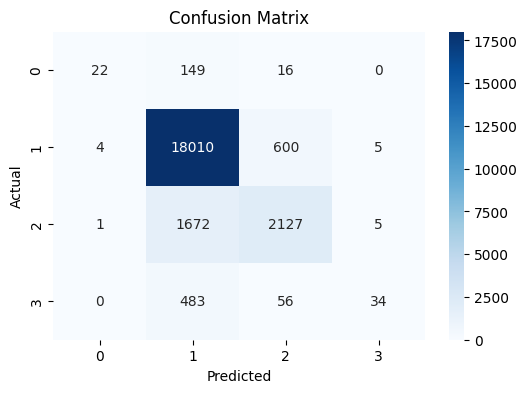

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.12      0.21       187
           2       0.89      0.97      0.93     18619
           3       0.76      0.56      0.64      3805
           4       0.77      0.06      0.11       573

    accuracy                           0.87     23184
   macro avg       0.81      0.43      0.47     23184
weighted avg       0.86      0.87      0.85     23184



In [6]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


#### XGBoost

In [11]:
(y_train-1).unique()

xgb_classifier = XGBClassifier(objective='multi:softmax',random_state=42)
xgb_classifier.fit(X_train, y_train-1 )

y_pred = xgb_classifier.predict(X_test)
#probas = xgb_classifier.predict_proba(X_test)  # Obtén las probabilidades de predicción
Eval_xgb=classification_task(xgb_classifier,X_train, y_train-1, X_test, y_test-1, y_pred,'XGBoost')
Eval_xgb


,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
XGBoost,0.936317,0.87927,0.870039,0.87927,0.87157,0.87927


Accuracy: 0.88


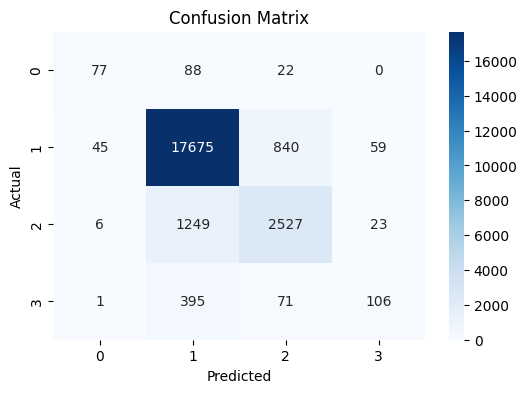

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.41      0.49       187
           1       0.91      0.95      0.93     18619
           2       0.73      0.66      0.70      3805
           3       0.56      0.18      0.28       573

    accuracy                           0.88     23184
   macro avg       0.70      0.55      0.60     23184
weighted avg       0.87      0.88      0.87     23184



In [12]:
accuracy = accuracy_score(y_test-1, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test-1, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test-1, y_pred)
print("Classification Report:")
print(class_report)

#### Balanced Bagging Classifier
Un Balanced Bagging Classifier es una técnica de aprendizaje automático en ensamblado que combina el enfoque de bagging con un equilibrio de clases mediante re-muestreo, ideal para problemas de clasificación con clases desbalanceadas (cuando una clase tiene significativamente más instancias que otra).


In [13]:
base_estimator = DecisionTreeClassifier(random_state=42)
balanced_bagging = BalancedBaggingClassifier(estimator=base_estimator, n_estimators=100, random_state=42)

balanced_bagging.fit(X_train, y_train)

y_pred = balanced_bagging.predict(X_test)
Eval_bbc=classification_task(balanced_bagging,X_train, y_train ,X_test,y_test, y_pred,'BBC')
Eval_bbc

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
BBC,0.701974,0.688708,0.874482,0.688708,0.74941,0.688708


Accuracy: 0.69


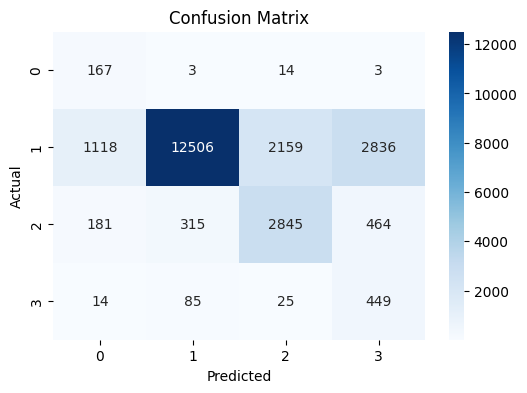

Classification Report:
              precision    recall  f1-score   support

           1       0.11      0.89      0.20       187
           2       0.97      0.67      0.79     18619
           3       0.56      0.75      0.64      3805
           4       0.12      0.78      0.21       573

    accuracy                           0.69     23184
   macro avg       0.44      0.77      0.46     23184
weighted avg       0.87      0.69      0.75     23184



In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

#### ADA Boost
AdaBoost combina varios modelos sencillos, enfocándose en corregir los errores de clasificación, para construir un modelo más fuerte y preciso. Es ideal para mejorar el poder predictivo utilizando la fuerza de múltiples clasificadores.

In [36]:
ada_classifier = AdaBoostClassifier(random_state=42)
ada_classifier.fit(X_train, y_train)

y_pred = ada_classifier.predict(X_test)
Eval_ada=classification_task(ada_classifier,X_train, y_train ,X_test,y_test, y_pred,'ADABoost')
Eval_ada

d:\MIAD\despliegue de soluciones\Proyecto_Accidentes_Transito_EU\DSA_Proyecto_AccidentesTransito\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
ADABoost,0.826142,0.827079,0.817364,0.827079,0.821345,0.827079


Accuracy: 0.83


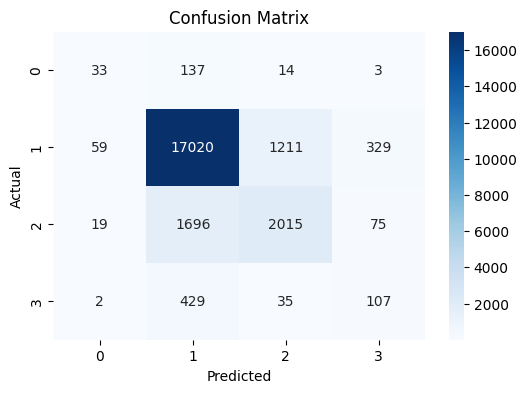

Classification Report:
              precision    recall  f1-score   support

           1       0.29      0.18      0.22       187
           2       0.88      0.91      0.90     18619
           3       0.62      0.53      0.57      3805
           4       0.21      0.19      0.20       573

    accuracy                           0.83     23184
   macro avg       0.50      0.45      0.47     23184
weighted avg       0.82      0.83      0.82     23184



In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

#### Decision Trees
Un árbol de decisión es un modelo de aprendizaje supervisado no paramétrico utilizado en tareas de clasificación y regresión. Su estructura jerárquica se asemeja a un árbol, compuesto por un nodo raíz, ramas, nodos internos y nodos hoja. Este modelo se basa en declaraciones condicionales para realizar divisiones en función de características, permitiendo llegar a predicciones finales representadas en los nodos hoja.

In [24]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)
Eval_Dt=classification_task(dt_classifier,X_train, y_train ,X_test ,y_test, y_pred,'Decision Trees')
Eval_Dt

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Decision Trees,0.999982,0.819703,0.823019,0.819703,0.821292,0.819703


Accuracy: 0.82


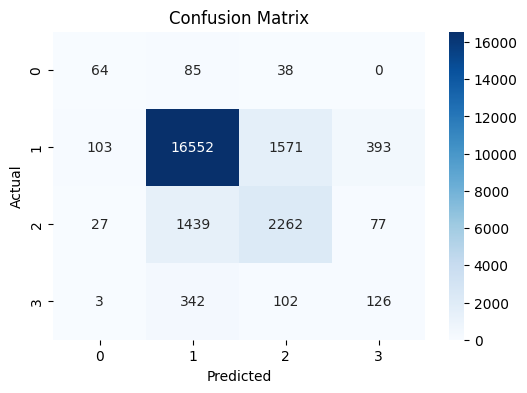

Classification Report:
              precision    recall  f1-score   support

           1       0.32      0.34      0.33       187
           2       0.90      0.89      0.89     18619
           3       0.57      0.59      0.58      3805
           4       0.21      0.22      0.22       573

    accuracy                           0.82     23184
   macro avg       0.50      0.51      0.51     23184
weighted avg       0.82      0.82      0.82     23184



In [25]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


#### Voting Classifier 

Un Voting Classifier es un modelo de aprendizaje automático que combina varios modelos para predecir una clase basándose en la probabilidad más alta asignada por ellos. En lugar de evaluar modelos individuales por separado, este enfoque entrena un modelo único que utiliza los resultados de varios clasificadores para predecir una clase basándose en la mayoría de votos. Existen dos tipos de votaciones:

Votación dura (Hard Voting): La clase predicha es aquella con la mayor cantidad de votos. Por ejemplo, si tres clasificadores predicen las clases (A, A, B), la clase final será A, ya que obtuvo la mayoría de votos.

Votación blanda (Soft Voting): La predicción se basa en el promedio de las probabilidades asignadas por cada clasificador. Por ejemplo, si las probabilidades para la clase A son (0.30, 0.47, 0.53) y para B son (0.20, 0.32, 0.40), se calculan los promedios: A = 0.4333 y B = 0.3067. La clase A será la predicha, ya que tiene el promedio más alto.

Este enfoque mejora la precisión combinando los puntos fuertes de múltiples clasificadores.

In [26]:
voting_classifier = VotingClassifier(estimators=[
    ('ada', ada_classifier),
    ('dt_classifier',dt_classifier),
    ('rf_classifier',rf_classifier),
    ('xgb', xgb_classifier),
    ('bbc',balanced_bagging)
], voting='soft') 

voting_classifier.fit(X_train, y_train)

y_pred = voting_classifier.predict(X_test)

Eval_voting=classification_task(voting_classifier,X_train, y_train ,X_test,y_test, y_pred,'voting')
Eval_voting

d:\MIAD\despliegue de soluciones\Proyecto_Accidentes_Transito_EU\DSA_Proyecto_AccidentesTransito\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
voting,0.997523,0.867581,0.861254,0.867581,0.863738,0.867581


Accuracy: 0.87


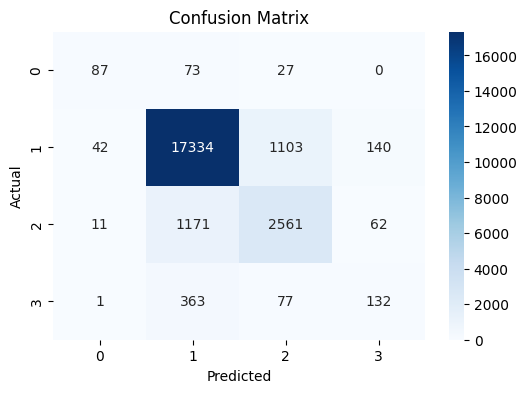

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.47      0.53       187
           2       0.92      0.93      0.92     18619
           3       0.68      0.67      0.68      3805
           4       0.40      0.23      0.29       573

    accuracy                           0.87     23184
   macro avg       0.65      0.57      0.61     23184
weighted avg       0.86      0.87      0.86     23184



In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

In [28]:
pd.concat([Eval_voting , Eval_ada , Eval_Dt, Eval_xgb ,Eval_Rf, Eval_bbc])

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
voting,0.997523,0.867581,0.861254,0.867581,0.863738,0.867581
ADABoost,0.826142,0.827079,0.817364,0.827079,0.821345,0.827079
Decision Trees,0.999982,0.819703,0.823019,0.819703,0.821292,0.819703
XGBoost,0.936317,0.879270,0.870039,0.879270,0.871570,0.879270
Random Forest,0.999982,0.870989,0.862399,0.870989,0.853111,0.870989
BBC,0.701974,0.688708,0.874482,0.688708,0.749410,0.688708


### Mejor modelo con balanceo de datos

In [34]:
## xgboost con data de train balanceada
(y_resampled-1).unique()

xgb_classifier = XGBClassifier(objective='multi:softmax',random_state=42)
xgb_classifier.fit(X_resampled, y_resampled-1 )

y_pred = xgb_classifier.predict(X_test)
Eval_xgb_balan=classification_task(xgb_classifier,X_resampled, y_resampled-1, X_test, y_test-1, y_pred,'XGBoost')
Eval_xgb_balan


,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
XGBoost,0.963597,0.863138,0.859186,0.863138,0.860803,0.863138


Accuracy: 0.86


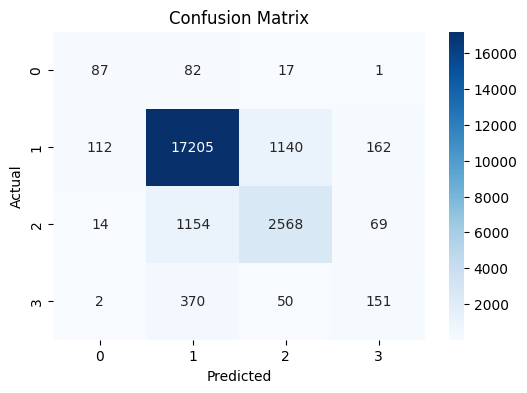

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.47      0.43       187
           1       0.91      0.92      0.92     18619
           2       0.68      0.67      0.68      3805
           3       0.39      0.26      0.32       573

    accuracy                           0.86     23184
   macro avg       0.60      0.58      0.59     23184
weighted avg       0.86      0.86      0.86     23184



In [35]:
accuracy = accuracy_score(y_test-1, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test-1, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test-1, y_pred)
print("Classification Report:")
print(class_report)

#### write

In [14]:
results_df['Actual'] = y_test   # Ajusta el índice de clase restando 1, si es necesario
results_df['Predicted'] = y_pred + 1

# Define la ruta y el nombre del archivo CSV donde guardar los resultados
results_path = '../Results'
file_path = os.path.join(results_path, 'XGBoost_Predictions_with_Features.csv')

# Guarda el DataFrame en un archivo CSV
results_df.to_csv(file_path, index=False)

print("Archivo CSV con predicciones y variables de X_test guardado exitosamente en:", file_path)


Archivo CSV con predicciones y variables de X_test guardado exitosamente en: ../Results\XGBoost_Predictions_with_Features.csv


In [16]:
# Definir la ruta a la carpeta Data
Data_path = '../Data'
# Cargar los datos
file_path = os.path.join(Data_path, 'US_Accidents_March23.csv')

# Cargar el dataset original y el archivo de predicciones
dataset_original = pd.read_csv(file_path)  # Desde el repositorio DVC
#predicciones_test = results_df  # Archivo con predicciones




In [20]:
# Asegúrate de que ambos datasets tienen una columna común para unir (por ejemplo, 'ID')
# Si el índice es común, puedes resetearlo con reset_index()
dataset_original.set_index('ID', inplace=True)
results_df.set_index('ID', inplace=True)

# Unir las predicciones al dataset original
dataset_con_predicciones = dataset_original.join(results_df[['Predicted']], how='inner')


In [21]:
dataset_con_predicciones

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Predicted
ID,,,,,,,,,,,,,,,,,,,,,
A-849,Source2,2,2016-06-22 10:08:16,2016-06-22 10:38:16,37.488846,-122.212852,NaN,NaN,0.000,Right hand shoulder blocked due to accident on...,...,False,False,False,False,False,Day,Day,Day,Day,2
A-1132,Source2,2,2016-06-24 13:04:21,2016-06-24 13:34:21,37.902702,-122.515602,NaN,NaN,0.000,Slow lane blocked due to accident on US-101 No...,...,False,False,False,False,False,Day,Day,Day,Day,2
A-1214,Source2,2,2016-06-25 02:23:05,2016-06-25 03:08:05,38.405514,-121.996033,NaN,NaN,0.000,Accident on Gibson Canyon Rd at Shelly Ln.,...,False,False,False,False,False,Night,Night,Night,Night,2
A-2929,Source2,3,2016-07-13 13:01:53,2016-07-13 13:31:53,37.803886,-122.301971,NaN,NaN,0.000,Right hand shoulder blocked due to accident on...,...,False,False,False,False,False,Day,Day,Day,Day,3
A-3723,Source2,2,2016-07-21 20:21:06,2016-07-21 21:36:06,38.476143,-121.424957,NaN,NaN,0.000,Queueing traffic due to accident on CA-99 Sout...,...,False,False,False,False,False,Day,Day,Day,Day,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A-7775951,Source1,3,2019-08-20 07:31:08,2019-08-20 08:00:52,39.780040,-104.931710,39.778290,-104.90927,1.198,At Monaco St/Exit 277 - Accident.,...,False,False,False,True,False,Day,Day,Day,Day,3
A-7776138,Source1,2,2019-08-20 15:27:20,2019-08-20 19:27:20,43.261364,-123.358492,43.279827,-123.35550,1.285,At Co Rd 115/Del Rio Rd/Exit 129 - Accident.,...,False,False,False,False,False,Day,Day,Day,Day,2
A-7776268,Source1,2,2019-08-21 19:10:12,2019-08-21 19:39:37,42.319000,-83.688450,42.323770,-83.69795,0.587,At M-14/Exit 42 - Accident. Left lane blocked.,...,False,False,False,False,False,Day,Day,Day,Day,2


In [22]:
# Define la ruta y el nombre del archivo CSV donde guardar los resultados
results_path = '../Results'
file_path = os.path.join(results_path, 'XGBoost_Predictions_with_Features_originales.csv')

# Guarda el DataFrame en un archivo CSV
dataset_con_predicciones.to_csv(file_path, index=False)

print("Archivo CSV con predicciones y variables originales de X_test guardado exitosamente en:", file_path)

Archivo CSV con predicciones y variables originales de X_test guardado exitosamente en: ../Results\XGBoost_Predictions_with_Features_originales.csv
